Here we show how to use our models.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
import sys

# Add the relative path to the system path
sys.path.append(os.path.abspath("../train"))

from PIL import Image

import torch as th
from torch.utils.data import Dataset
from torch import nn
from torchvision import transforms

from ConvLSTM_model import ConvLSTM_Model

from IPython.display import Image

In [2]:
id_data = pd.read_csv('../data/id_df_final_10.csv')

seq_len = id_data.groupby('sequence').size()
seq_len = seq_len.to_dict()
seq_rain = id_data.groupby('sequence')['rain_category'].mean()
seq_rain = seq_rain.to_dict()

seq_df = pd.DataFrame({'seq_len': seq_len, 'seq_rain': seq_rain})

# split the sequences in train and test set (80/20)
train_seq = seq_df.sample(frac=0.8, random_state=1)
test_seq = seq_df.drop(train_seq.index)

# get the sequences of the train and test set
train_seq_idx = train_seq.index
test_seq_idx = test_seq.index
train_data = id_data[id_data['sequence'].isin(train_seq_idx)]
test_data = id_data[id_data['sequence'].isin(test_seq_idx)]


In [3]:
ids = [test_data.iloc[i]["id"] for i in range(20)]
images = [f"tensor_{id}.pt" for id in ids]
images

['tensor_2453267.pt',
 'tensor_2453247.pt',
 'tensor_2453227.pt',
 'tensor_2453209.pt',
 'tensor_2453187.pt',
 'tensor_2453147.pt',
 'tensor_2453127.pt',
 'tensor_2453107.pt',
 'tensor_2453087.pt',
 'tensor_2453067.pt',
 'tensor_2453047.pt',
 'tensor_2453007.pt',
 'tensor_2452987.pt',
 'tensor_2452967.pt',
 'tensor_2452949.pt',
 'tensor_2452927.pt',
 'tensor_2452907.pt',
 'tensor_2452867.pt',
 'tensor_2452847.pt',
 'tensor_2452827.pt']

In [4]:
batch_size = 1
num_hidden = [32, 16, 16, 32]
num_layers = len(num_hidden)
custom_model_config = {
    'in_shape': [1, 128, 128], # T, C, H, W
    'patch_size': 1,
    'filter_size': 1, # given to ConvLSTMCell
    'stride': 1, # given to ConvLSTMCell
    'layer_norm' : False, # given to ConvLSTMCell
    # the sum of pre_seq_length and aft_seq_length has to be = len(inputs)
    'pre_seq_length': 3,
    'aft_seq_length': 2,
    'target_seq_length': 5,
    'reverse_scheduled_sampling': 0,
    'batch_size': batch_size
}

if th.cuda.is_available():
    print("CUDA is available!")
else:
    print("CUDA is not available.")

device = th.device("cuda" if th.cuda.is_available() else "cpu")

# Instantiate the model
input_dim = 3  # Assuming x_train shape is (batch_size, sequence_length, channels, height, width)
model = ConvLSTM_Model(num_layers, num_hidden, custom_model_config)

# Load the model
# Load the state dictionary
state_dict = th.load('../models/model.pth', map_location=th.device('cpu'))

# Remove `module.` prefix if it exists
new_state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}

# Load the adjusted state dict into the model
model.load_state_dict(new_state_dict, strict=False)

CUDA is not available.


/var/folders/tp/vfdk9pcj66g2trgt19fh08480000gn/T/ipykernel_10199/3948323015.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = th.load('../models/model.pth', 

<All keys matched successfully>

In [5]:
input_row = images[0:10]
output_row = images[10:]

input_frames = [th.load(f"../data/images/{image}") for image in input_row]
output_frames = [th.load(f"../data/images/{image}") for image in output_row]

input_pil_frames = [transforms.ToPILImage()(frame) for frame in input_frames]
true_pil_frames = [transforms.ToPILImage()(frame) for frame in output_frames]

true_gif_list = input_pil_frames + true_pil_frames
true_gif_list[0].save('true.gif', save_all=True, append_images=true_gif_list[1:], duration=1, loop=0)

input_frames_tensor = th.stack(input_frames, dim=0)
input_frames_tensor = input_frames_tensor.unsqueeze(0)
mask_true = th.ones(input_frames_tensor.shape)
predicted_frames = model(input_frames_tensor, mask_true)
predicted_frames = predicted_frames.squeeze(0)
predicted_pil_frames = [transforms.ToPILImage()(frame) for frame in predicted_frames]
pred_gif_list = input_pil_frames + predicted_pil_frames

# List of frames as PIL Image objects
# Duration sets the display time for each frame in milliseconds
# Loop sets the number of loops. Default is 0 and means infinite

pred_gif_list[0].save('pred.gif', save_all=True, append_images=pred_gif_list[1:], duration=1, loop=0)

/var/folders/tp/vfdk9pcj66g2trgt19fh08480000gn/T/ipykernel_10199/3163855201.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  input_frames = [th.load(f"../data/images/{ima

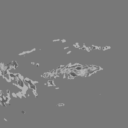

In [6]:
Image(filename='pred.gif')

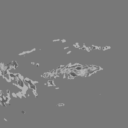

In [7]:
Image(filename='true.gif')

In [8]:
from IPython.display import HTML

# Display two GIFs horizontally aligned with titles on top of each
HTML('''
    <div style="display: flex; justify-content: space-around; align-items: center;">
        <div style="text-align: center;">
            <h3>True Sequence</h3>
            <img src="output.gif" width="300px">
        </div>
        <div style="text-align: center;">
            <h3>Predicted Sequence</h3>
            <img src="output.gif" width="300px">
        </div>
    </div>
''')
